# Key-Value Attention Mechanism Homework on Keras: Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with key-value attention mechnism that coverts names of constituency MP candidates in the 2019 Thai general election from Thai script to Roman(Latin) script. E.g. นิยม-->niyom 

In [1]:
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

# import tensorflow as tf
# print(tf.__version__)

# import matplotlib as mpl
# from matplotlib import font_manager
# mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
# mpl.rc('font', family='TH Sarabun New')

In [2]:
%matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of constituency MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/dataset_diagram.png" alt="Drawing" style="width: 500px;"/>


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# import shutil
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/mp_name_th_en.csv", "/content/mp_name_th_en.csv")

In [5]:
import csv
with open('Dataset/mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        name_th.append(row[0])
        name_en.append(row[1])

In [6]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## Task1: Preprocess dataset for Keras
* 2 dictionaries for indexing (1 for input and another for output) OK!
* DON'T FORGET TO INCLUDE special token for padding OK!
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output) OK!
* Be mindful of your pad_sequences "padding" hyperparameter. Choose wisely (post-padding vs pre-padding) OK!

In [7]:
#FILL YOUR CODE HERE
print("th : {:d} | en : {:d}".format(len(name_th),len(name_en)))

th : 10887 | en : 10887


In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda, Reshape, SimpleRNN
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import numpy as np

In [9]:
sequence = [[1], [2, 3], [4, 5, 6]]
b = pad_sequences(sequence, padding='pre')
a = pad_sequences(sequence, padding='post')
print(b)
print(a)


[[0 0 1]
 [0 2 3]
 [4 5 6]]
[[1 0 0]
 [2 3 0]
 [4 5 6]]


In [10]:
print(name_th[0])

ไกรสีห์


In [11]:
input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))
# +1 for padding +1 for the end of word
data_size, vocab_size = len(name_th), len(input_chars)+2 
output_vocab_size = len(output_chars)+2

print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
maxlen_th = len( max(name_th, key=len)) #max input length
print("Max input length:", maxlen_th)
maxlen_en = len( max(name_en, key=len)) #max input length
print("Max output length:", maxlen_en)

There are 10887 lines and 66 unique characters in your input data.
There are 10887 lines and 66 unique characters in your input data.
Max input length: 20
Max output length: 19


In [12]:
sorted_chars= sorted(input_chars)
sorted_output_chars= sorted(output_chars)
sorted_chars.insert(0,"<PAD>") #PADDING for input
sorted_output_chars.insert(0,"<PAD>") #PADDING for output
sorted_chars.insert(1,"</S>") #the end of word for input
sorted_output_chars.insert(1,"</S>") #the end of word for output
#Input
char_to_ix = { ch:i for i,ch in enumerate(sorted_chars) }
ix_to_char = { i:ch for i,ch in enumerate(sorted_chars) } #reverse dictionary
#Output
output_char_to_ix = { ch:i for i,ch in enumerate(sorted_output_chars) }
ix_to_output_char = { i:ch for i,ch in enumerate(sorted_output_chars) } #reverse dictionary

print(ix_to_char)
print(ix_to_output_char)
print("len(input) : %d | len(output) %d" % (len(ix_to_char),len(ix_to_output_char)))

{0: '<PAD>', 1: '</S>', 2: ' ', 3: 'ก', 4: 'ข', 5: 'ค', 6: 'ฆ', 7: 'ง', 8: 'จ', 9: 'ฉ', 10: 'ช', 11: 'ซ', 12: 'ฌ', 13: 'ญ', 14: 'ฎ', 15: 'ฏ', 16: 'ฐ', 17: 'ฑ', 18: 'ฒ', 19: 'ณ', 20: 'ด', 21: 'ต', 22: 'ถ', 23: 'ท', 24: 'ธ', 25: 'น', 26: 'บ', 27: 'ป', 28: 'ผ', 29: 'ฝ', 30: 'พ', 31: 'ฟ', 32: 'ภ', 33: 'ม', 34: 'ย', 35: 'ร', 36: 'ล', 37: 'ว', 38: 'ศ', 39: 'ษ', 40: 'ส', 41: 'ห', 42: 'ฬ', 43: 'อ', 44: 'ฮ', 45: 'ะ', 46: 'ั', 47: 'า', 48: 'ำ', 49: 'ิ', 50: 'ี', 51: 'ึ', 52: 'ื', 53: 'ุ', 54: 'ู', 55: 'เ', 56: 'แ', 57: 'โ', 58: 'ใ', 59: 'ไ', 60: '็', 61: '่', 62: '้', 63: '๊', 64: '๋', 65: '์'}
{0: '<PAD>', 1: '</S>', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'w', 23: 'y'}
len(input) : 66 | len(output) 24


In [13]:
m=10887  # #sample
Tx=maxlen_th # size of input = 20
Ty=maxlen_en+1 # size of output = 19
print(Ty)

20


In [14]:
X = []
for line in name_th:
    temp=[]
    for char in line:
        temp.append(char_to_ix[char])
    temp.append(char_to_ix["</S>"])
    X.append(temp)
Y = []
for line in name_en:
    temp=[]
    for char in line:
        temp.append(output_char_to_ix[char])
    temp.append(char_to_ix["</S>"])
    Y.append(temp)    

print(len(Y),output_vocab_size)
print("Example X :"+str(X))
print("Example Y :"+str(Y))

X = pad_sequences(X,maxlen=maxlen_th,padding = 'pre')
Y = pad_sequences(Y,maxlen=Ty,padding = 'pre')

X= to_categorical(X,vocab_size)
X=X.reshape(data_size,maxlen_th ,vocab_size)

Y= to_categorical(Y,output_vocab_size)
Y=Y.reshape(data_size,Ty ,output_vocab_size)
print("X : %s | Y : %s" % (str(X.shape),str(Y.shape)))

10887 24
Example X :[[59, 3, 35, 40, 50, 41, 65, 1], [30, 46, 10, 35, 50, 1], [24, 50, 35, 45, 1], [37, 53, 18, 49, 3, 35, 1], [59, 40, 37, 1], [40, 46, 33, 32, 47, 39, 19, 65, 2, 1], [37, 38, 49, 25, 1], [23, 49, 25, 37, 46, 18, 25, 65, 1], [38, 46, 3, 20, 49, 25, 46, 34, 1], [40, 53, 35, 38, 46, 3, 20, 49, 65, 1], [55, 43, 3, 43, 35, 53, 19, 1], [5, 33, 38, 46, 3, 20, 49, 65, 1], [3, 49, 21, 21, 49, 24, 46, 10, 1], [3, 35, 49, 61, 33, 1], [43, 48, 30, 35, 1], [35, 46, 16, 1], [37, 50, 35, 45, 10, 46, 34, 1], [40, 53, 37, 35, 35, 19, 1], [40, 53, 32, 47, 30, 1], [24, 25, 49, 25, 23, 65, 24, 35, 1], [40, 47, 37, 49, 21, 35, 50, 1], [24, 46, 13, 37, 35, 49, 25, 23, 35, 65, 1], [36, 46, 20, 20, 47, 1], [59, 30, 35, 46, 21, 25, 65, 1], [10, 54, 55, 3, 50, 34, 35, 21, 49, 1], [24, 25, 32, 46, 23, 35, 1], [35, 30, 50, 30, 7, 38, 65, 1], [33, 47, 35, 49, 40, 47, 1], [24, 25, 37, 46, 18, 25, 65, 1], [35, 46, 10, 15, 45, 1], [25, 49, 35, 46, 16, 1], [40, 33, 30, 7, 39, 65, 1], [40, 53, 35, 49,

In [15]:
print(X[0].shape)
print(Y[0].shape)
print(X[1].shape)
print(Y[1].shape)

(20, 66)
(20, 24)
(20, 66)
(20, 24)


# Attention Mechanism
## Task 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* Define global variables
* fill code for one_step_attention function
* Hint: use keras.layers.Lambda 
* Hint: you will probably need more hidden dimmensions than what you've seen in the demo


In [16]:
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Lambda
from tensorflow import split
def softMaxAxis1(x):
    return softmax(x,axis=1)


In [17]:
#These are global variables (shared layers)
## Fill your code here
## you are allowed to use code in the demo as your template. 

repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)

#Key-values (Hint)
splitter = Lambda(lambda x:split(x, num_or_size_splits=2,axis=2)) #ได้ key กับ value

#Attention function###
fattn_1 = Dense(128, activation = "tanh")
fattn_2 = Dense(1, activation = "tanh")

#Attention function###
###
activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)


In [18]:
def one_step_attention(hidden, s_prev): # (hidden,vecter)

    #Fill code here
    key, value = splitter(hidden)

    #return None # return whatever you need to complete this homework 
    s_prev = repeator(s_prev)
    concat = concatenator([key,s_prev])
    # attention function
    e = fattn_1(concat)
    energies =fattn_2(e)
    # calculate attention_scores (softmax)
    attention_scores = activator(energies)
    #calculate a context vector
    context = dotor([attention_scores,value])

    return context,attention_scores,energies

## Task3: Create and train your encoder/decoder model here
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo

In [19]:
n_h = 64 #hidden dimensions for encoder 
n_s = 128 #hidden dimensions for decoder
encoder_LSTM =  Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))
decoder_LSTM_cell = LSTM(n_s, return_state = True) #decoder_LSTM_cell
output_layer = Dense(output_vocab_size, activation="softmax") #softmax output layer

In [20]:
#FILL CODE HERE :Hint --> heatmap in CNN + GradCAM

def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):

    # Define the input of your model
    X = Input(shape=(Tx, vocab_size))
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    # print(type(s))
    # print(type(c))
    # Initialize empty list of outputs
    outputs = list()

    #Encoder Bi-LSTM
    # h = BidirectionaM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))(X)
    h = encoder_LSTM(X)
    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context,attention_scores,energies = one_step_attention(h, s)
       
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])
           
        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)
        
        # Append an output list with the current output
        outputs.append(out)
    
    #Create model instance
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return model



def inference_encoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    X = Input(shape=(Tx, vocab_size))

    h = encoder_LSTM(X)

    model_inference_encoder = Model(inputs=[X],outputs=h)

    return model_inference_encoder

def inference_decoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    h = Input(shape=(Tx,n_h*2), name='h')
    s = s0
    c = c0

    context, attention_scores, energies = one_step_attention(h, s)

    s, _, c = decoder_LSTM_cell(context, initial_state=[s, c])

    out = output_layer(s)

    model_inference_encoder = Model(inputs=[h, s0, c0], outputs=[out, s, c, attention_scores, energies])

    return model_inference_encoder




In [21]:
# FIT YOUR MODEL HERE
model = model(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)

In [22]:
# model.summary()

In [23]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Y.swapaxes(0,1))
opt=Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy')
model.fit([X, s0, c0], outputs, epochs=20, batch_size=120)


Epoch 1/20
91/91 [==============================] - 48s 84ms/step - loss: 28.1665 - dense_2_loss: 0.3009 - dense_2_1_loss: 0.2059 - dense_2_2_loss: 0.2011 - dense_2_3_loss: 0.2142 - dense_2_4_loss: 0.2350 - dense_2_5_loss: 0.2715 - dense_2_6_loss: 0.3283 - dense_2_7_loss: 0.4294 - dense_2_8_loss: 0.5847 - dense_2_9_loss: 0.8656 - dense_2_10_loss: 1.2496 - dense_2_11_loss: 1.7595 - dense_2_12_loss: 2.3580 - dense_2_13_loss: 2.7525 - dense_2_14_loss: 2.9508 - dense_2_15_loss: 2.9543 - dense_2_16_loss: 3.1913 - dense_2_17_loss: 2.8831 - dense_2_18_loss: 2.8361 - dense_2_19_loss: 1.5945
Epoch 2/20
91/91 [==============================] - 8s 84ms/step - loss: 22.0053 - dense_2_loss: 0.0142 - dense_2_1_loss: 0.0030 - dense_2_2_loss: 0.0081 - dense_2_3_loss: 0.0143 - dense_2_4_loss: 0.0228 - dense_2_5_loss: 0.0463 - dense_2_6_loss: 0.0876 - dense_2_7_loss: 0.1680 - dense_2_8_loss: 0.3063 - dense_2_9_loss: 0.5550 - dense_2_10_loss: 0.9208 - dense_2_11_loss: 1.4261 - dense_2_12_loss: 2.0078 - d

# Thai-Script to Roman-Script Translation
* Task 4: Test your model on 5 examples of your choice including your name! 
* Task 5: Show your visualization of attention scores on one of your example 

In [24]:
#task 4
#fill your code here
def prep_input(input_list):
    X = []
    for line in input_list:
        temp=[]
        for char in line:
            temp.append(char_to_ix[char])
        X.append(temp)
    X = pad_sequences(X,maxlen=maxlen_th)
    X= to_categorical(X,vocab_size)
    X=X.reshape(len(input_list),maxlen_th ,vocab_size)
    
    return X

EXAMPLES = ['รณกร', 'ธนัท', 'เบส', 'ปุ่น', 'ติน']
s0 = np.zeros((len(EXAMPLES), n_s))
c0 = np.zeros((len(EXAMPLES), n_s))
EXAMPLES = prep_input(EXAMPLES)

prediction = model.predict([EXAMPLES , s0, c0])
# print(type(prediction))
# print(len(prediction))
# print(prediction)
prediction = np.swapaxes(prediction,0,1)
prediction = np.argmax(prediction, axis = -1)
# print(prediction)

for j in range(len(prediction)):
    output = "".join([ix_to_output_char[int(i)] for i in prediction[j]])
    print(output)


1/1 [==============================] - 9s 9s/step
<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>nongro</S>
<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>thantha</S>
<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>sset</S>
<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>nui</S>
<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>tiia</S>


### Plot the attention map
* If you need to install thai font: sudo apt install xfonts-thai
* this is what your visualization might look like:
--> https://drive.google.com/file/d/168J5SPSf4NNKj718wWUEDpUbh8QYZKux/view?usp=share_link

In [25]:
# hit attention_scores in one step attention

In [43]:
EXAMPLES = ['สมชาย','สมศักดิ์','อดัม','ก้องภพ','ธนัท','ใจดี']
temp = EXAMPLES
inferEncoder_model = inference_encoder(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)
inferDecoder_model = inference_decoder(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)

s0 = np.zeros((len(EXAMPLES), n_s))
c0 = np.zeros((len(EXAMPLES), n_s))
s = s0
c = c0

EXAMPLES = prep_input(EXAMPLES)
h = inferEncoder_model.predict(EXAMPLES,verbose=0)

Ty = 20
score = []
attention_list = []

for t in range(Ty):
    out,s,c,attention_scores,energies = inferDecoder_model.predict([h,s,c],verbose=0)
    score.append(out)
    # print(out)
    print(attention_scores.shape)
    print("attention_scores : ",attention_scores)
    attention_list.append(attention_scores)
    # array=np.array(out)
    
prediction = np.swapaxes(score,0,1)
prediction = np.argmax(prediction, axis = -1)

attention_list = np.array(attention_list)
output_list=[]

for j in range(len(prediction)):
    a = [ix_to_output_char[int(i)] for i in prediction[j]]
    output = "".join(a)
    output_list.append([[temp[j]],a])
    # output = output.replace('<PAD>','')
    # output = output.replace('<END>','')
    print(temp[j],output)  




(6, 20, 1)
attention_scores :  [[[0.06071962]
  [0.06074451]
  [0.060744  ]
  [0.06073767]
  [0.06072325]
  [0.06069881]
  [0.06066659]
  [0.06063188]
  [0.06059971]
  [0.06057278]
  [0.06055162]
  [0.06053562]
  [0.06052376]
  [0.06051503]
  [0.0605086 ]
  [0.00823322]
  [0.00822195]
  [0.00822167]
  [0.0082217 ]
  [0.05762792]]

 [[0.07547139]
  [0.07550232]
  [0.07550169]
  [0.07549383]
  [0.0754759 ]
  [0.07544553]
  [0.07540548]
  [0.07536233]
  [0.07532235]
  [0.07528888]
  [0.07526258]
  [0.0752427 ]
  [0.01023361]
  [0.01021949]
  [0.01064088]
  [0.01150201]
  [0.01031093]
  [0.01021922]
  [0.01021911]
  [0.02187975]]

 [[0.05884691]
  [0.05887103]
  [0.05887054]
  [0.05886441]
  [0.05885043]
  [0.05882676]
  [0.05879552]
  [0.05876188]
  [0.05873071]
  [0.05870461]
  [0.0586841 ]
  [0.0586686 ]
  [0.05865709]
  [0.05864863]
  [0.05864241]
  [0.0586378 ]
  [0.03300241]
  [0.00796816]
  [0.00796832]
  [0.0109997 ]]

 [[0.06712187]
  [0.06714939]
  [0.06714883]
  [0.06714183]
  [

In [44]:
#task 5
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family']='TH Sarabun New'  #you can change to other font that works for you
#fill your code here

In [45]:

print("(number , Ty)",prediction.shape)
attention_list = np.swapaxes(attention_list,0,1)
print(attention_list)
print("(number Tx , Ty )",attention_list.shape)

(number , Ty) (6, 20)
[[[[0.06071962]
   [0.06074451]
   [0.060744  ]
   ...
   [0.00822167]
   [0.0082217 ]
   [0.05762792]]

  [[0.05      ]
   [0.05      ]
   [0.05      ]
   ...
   [0.05      ]
   [0.05      ]
   [0.05      ]]

  [[0.05      ]
   [0.05      ]
   [0.05      ]
   ...
   [0.05      ]
   [0.05      ]
   [0.05      ]]

  ...

  [[0.05000002]
   [0.05000015]
   [0.05000015]
   ...
   [0.04999996]
   [0.04999996]
   [0.04999996]]

  [[0.05      ]
   [0.05000002]
   [0.05000002]
   ...
   [0.05      ]
   [0.05      ]
   [0.05      ]]

  [[0.04999999]
   [0.05000001]
   [0.05000001]
   ...
   [0.04999999]
   [0.04999999]
   [0.04999999]]]


 [[[0.07547139]
   [0.07550232]
   [0.07550169]
   ...
   [0.01021922]
   [0.01021911]
   [0.02187975]]

  [[0.04999999]
   [0.05000003]
   [0.05000002]
   ...
   [0.04999999]
   [0.04999999]
   [0.04999999]]

  [[0.05      ]
   [0.05      ]
   [0.05      ]
   ...
   [0.05      ]
   [0.05      ]
   [0.05      ]]

  ...

  [[0.05000126]
 

In [46]:
def get_word_indices(word_list):
    start_index = None
    end_index = None
    
    for i in range(len(word_list)):
        if word_list[i] != '<PAD>':
            if start_index is None:
                start_index = i
            if word_list[i] == '</S>':
                end_index = i
                break
    
    return start_index, end_index

In [47]:
import tensorflow as tf
print(tf.__version__)

import matplotlib
import matplotlib.font_manager as fm

fm.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
matplotlib.rc('font', family='TH Sarabun New')

2.11.0


(20, 20)
['s', 'o', 'm', 'c', 'h', 'a', 'i']
[[0.06071962 0.06074451 0.060744   0.06073767 0.06072325 0.06069881
  0.06066659 0.06063188 0.06059971 0.06057278 0.06055162 0.06053562
  0.06052376 0.06051503 0.0605086  0.00823322 0.00822195 0.00822167
  0.0082217  0.05762792]
 [0.05       0.05       0.05       0.05       0.05       0.05
  0.05       0.05       0.05       0.05       0.05       0.05
  0.05       0.05       0.05       0.05       0.05       0.05
  0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05       0.05
  0.05       0.05       0.05       0.05       0.05       0.05
  0.05       0.05       0.05       0.05       0.05       0.05
  0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05       0.05
  0.05       0.05       0.05       0.05       0.05       0.05
  0.05       0.05       0.05       0.05       0.05       0.05
  0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05       0.05
  0.05       0.05       0.05   

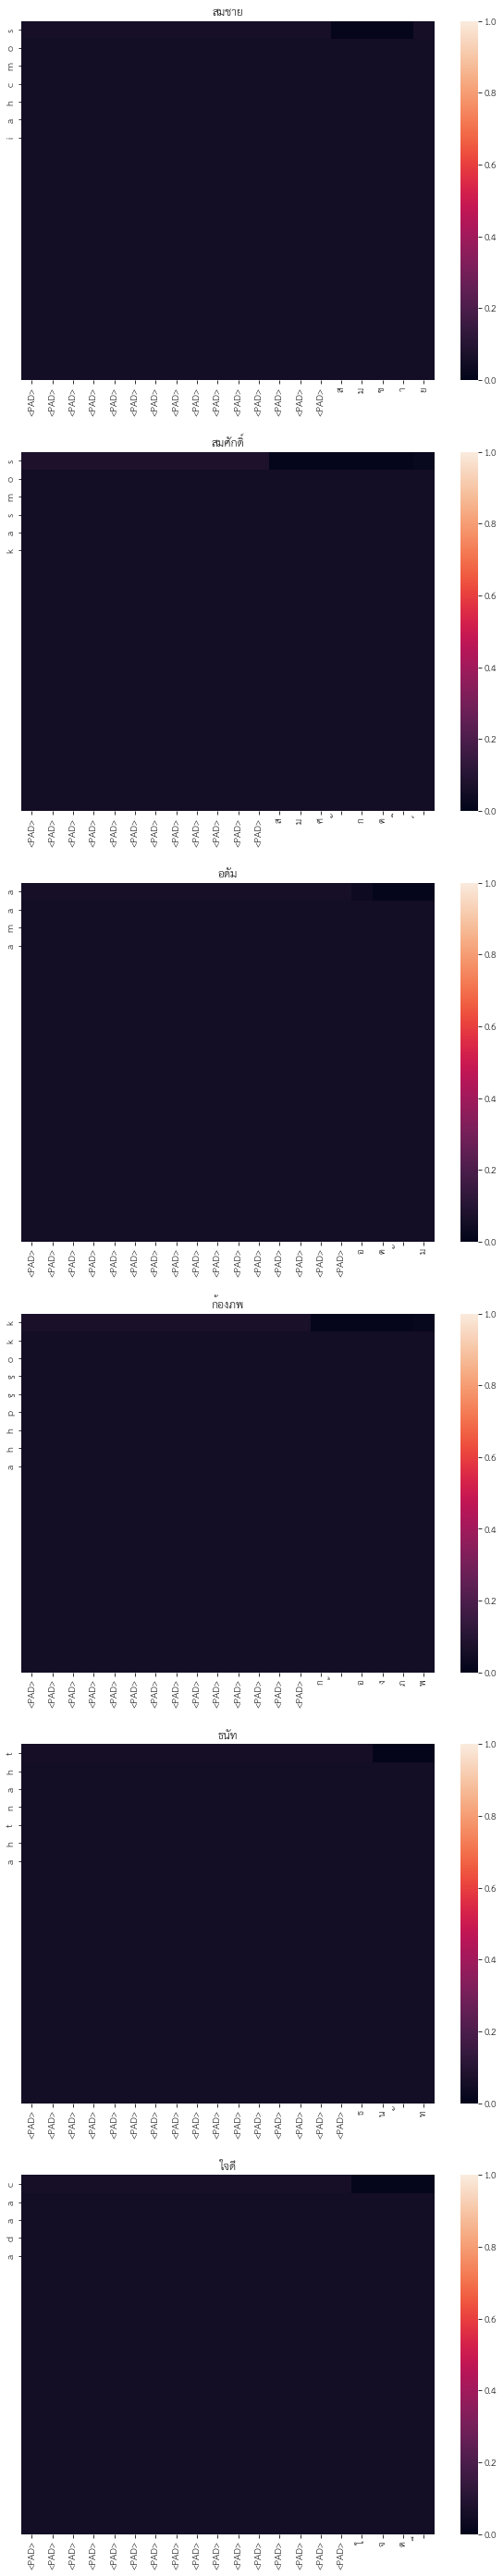

In [48]:
def plotheat(output_list,atten):
    fig, ax = plt.subplots(nrows = 6, figsize=(10,50))
    for index,i in enumerate(output_list) :
        word = i[0]
        word_padded = ['<PAD>']*(Tx - len(word[0])) + list(word[0]) 
        start,end = get_word_indices(i[1])
        att = atten[index]
        a = att.reshape(20,20)
        # a = a[start:end,:]
        print(a.shape)
        out = list(filter((lambda x : x != "<PAD>" and x != "</S>" ),i[1]) )
        print(out)
        print(a)
        sns.heatmap(a,xticklabels=word_padded, yticklabels=out, vmin=0, vmax=1 , ax=ax[index])
        ax[index].set_title(word[0])
        # break
    plt.show()

plotheat(output_list,attention_list)
# print(output_list[0][1])
# start,end = get_word_indices(output_list[0][1])
# print(start,end)